In [1]:
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
from pandas.io import sql
import snowflake.connector
import keyring
import psycopg2 
import time
from datetime import date, timedelta
from scipy import stats

pd.set_option('display.max_colwidth', 50)
pd.set_option('display.max_columns', 500)

from matplotlib import pyplot as plt
import seaborn as sns
color = sns.color_palette()
%matplotlib inline
sns.set_style("darkgrid")

In [2]:
snowflake_username = 'matthew.bessey@disneystreaming.com'

In [3]:
ctx = snowflake.connector.connect(authenticator='externalbrowser', 
                                  user=snowflake_username, 
                                  account='disneystreaming.us-east-1')

Initiating login request with your identity provider. A browser window should have opened for you to complete the login. If you can't see it, check existing browser windows, or your OS settings. Press CTRL+C to abort and try again...


In [4]:
# set date parameters for query

subscription_start_date_min = "'2019-12-01'"
subscription_start_date_max = "'2019-12-15'" # max of subscription start date
engagement_date = "'2020-01-20'" # date for which we want to pull engagement behaviors

In [5]:
query= """
select 
o.swid
, o.swid_holdout
, e.*
from account a
join oneid_combined o on a.swid = o.swid
join "DSS_PROD"."DISNEY_PLUS"."DIM_DISNEY_DAILY_ACCOUNT_ENGAGEMENT" e on a.accountid = e.account_id
where e.LAST_ACCOUNT_SUBSCRIPTION_SIGNUP_DATE >= {}
and e.LAST_ACCOUNT_SUBSCRIPTION_SIGNUP_DATE <= {}
and e.ds = {}
and e.is_pre_launch != 1
limit 500000;
""".format(subscription_start_date_min, subscription_start_date_max, engagement_date)

In [7]:
# run the query and write to engagement
engagement = pd.read_sql(query,ctx)

In [8]:
# map columns to lowercase
engagement.columns = engagement.columns.str.lower()

In [9]:
# create function and apply for mapping of holdout groups on 'swid_holdout'
def holdout_grouping(df):
    if df['swid_holdout'] < 243:
        return "all marketing"
    elif df['swid_holdout'] >= 243 and df['swid_holdout'] < 246:
        return "no onboarding"
    else:
        return "no marketing"
    
engagement['marketing_holdout'] = engagement.apply(holdout_grouping,axis=1)

In [10]:
#drop rows w/ no entitlement data, rewrite as int
engagement = engagement.drop(engagement[engagement['is_entitled']=='unknown'].index,axis=0)
engagement.is_entitled = engagement.is_entitled.astype(int)

In [11]:
# remove non-US countries and then country column
countryUS_filter = engagement['account_home_country'] == 'US'
engagementCleaned = engagement[countryUS_filter]
engagementCleaned = engagementCleaned.drop('account_home_country',axis=1)

In [12]:
# remove unnecessary columns
columnsToRemove = ['swid','swid_holdout','ds','account_id','is_flagged','first_account_subscription_signup_week',
    'last_account_subscription_signup_week','is_entitled_l1','is_entitled_l7','is_entitled_l28','is_entitled_itd',
    'is_pre_launch','is_pre_launch_nltt','account_home_country','subscription_state_upd','subscription_type',
    'total_login_days_l1','total_login_days_l28','total_streams_l1','total_streams_l28','num_streaming_profiles_l1',
    'num_streaming_profiles_l28','num_general_streaming_profiles_l1','num_general_streaming_profiles_l28',
    'num_kids_streaming_profiles_l1','num_kids_streaming_profiles_l28','num_streaming_devices_l1','num_streaming_devices_l28',
    'account_total_stream_days_l1','account_total_stream_days_l28','account_profile_total_stream_days_l1',
    'account_profile_total_stream_days_l28','total_stream_days_general_profiles_l1','total_stream_days_general_profiles_l28',
    'total_stream_days_kids_profiles_l1','total_stream_days_kids_profiles_l28','total_stream_time_ms_l1','total_stream_time_ms_l28',
    'total_stream_time_general_profiles_ms_l1','total_stream_time_general_profiles_ms_l28','total_stream_time_kids_profiles_ms_l1',
    'total_stream_time_kids_profiles_ms_l28','total_stream_time_web_ms_l1','total_stream_time_web_ms_l28','total_stream_time_mobile_ms_l1',
    'total_stream_time_mobile_ms_l28','total_stream_time_connected_tv_ms_l1','total_stream_time_connected_tv_ms_l28',
    'total_stream_time_unknown_ms_l1','total_stream_time_unknown_ms_l28','last_stream_date','account_profile_total_stream_days_l7',
    'account_profile_total_stream_days_itd','total_stream_time_unknown_ms_l7','total_stream_time_unknown_ms_itd'
]

engagementCleaned = engagement.drop(columnsToRemove,axis=1)

In [13]:
renamedColumns = ['first_signup_date','last_signup_date', 'is_entitled','ttl_login_days_l7', 'ttl_login_days_itd', 'ttl_streams_l7',
    'ttl_streams_itd', 'streaming_profiles_l7','streaming_profiles_itd', 'general_streaming_profiles_l7','general_streaming_profiles_itd', 
    'kids_streaming_profiles_l7','kids_streaming_profiles_itd', 'streaming_devices_l7','streaming_devices_itd', 'ttl_stream_days_l7',
    'ttl_stream_days_itd','ttl_stream_days_general_profiles_l7','ttl_stream_days_general_profiles_itd','ttl_stream_days_kids_profiles_l7',
    'ttl_stream_days_kids_profiles_itd', 'ttl_stream_time_ms_l7','ttl_stream_time_ms_itd', 'ttl_stream_time_general_profiles_ms_l7',
    'ttl_stream_time_general_profiles_ms_itd','ttl_stream_time_kids_profiles_ms_l7','ttl_stream_time_kids_profiles_ms_itd', 
    'ttl_stream_time_web_ms_l7','ttl_stream_time_web_ms_itd', 'ttl_stream_time_mobile_ms_l7','ttl_stream_time_mobile_ms_itd',
    'ttl_stream_time_connected_tv_ms_l7','tl_stream_time_connected_tv_ms_itd', 'days_since_last_stream','marketing_holdout'
]

engagementCleaned.columns = renamedColumns

In [14]:
# rename for conciseness
engmt = engagementCleaned
del engagementCleaned
del engagement

In [15]:
# define columns for binary construction
# binary = 1 if action occurred in interval, else 0

binaryConstructionList = [
    'ttl_login_days_l7','ttl_login_days_itd','ttl_streams_l7','ttl_streams_itd','general_streaming_profiles_l7', 
    'general_streaming_profiles_itd','kids_streaming_profiles_l7', 'kids_streaming_profiles_itd','ttl_stream_time_web_ms_l7',
    'ttl_stream_time_web_ms_itd','ttl_stream_time_mobile_ms_l7','ttl_stream_time_mobile_ms_itd', 'ttl_stream_time_connected_tv_ms_l7',
    'tl_stream_time_connected_tv_ms_itd','days_since_last_stream'
]

In [16]:
# create binary variables _bin
for i in binaryConstructionList:
    engmt[i + '_bin'] = engmt.apply(lambda df:
                                   1 if df[i] > 0
                                   else 0,
                                   axis=1)

In [52]:
#engmt.groupby('marketing_holdout').mean()

,is_entitled,ttl_login_days_l7,ttl_login_days_itd,ttl_streams_l7,ttl_streams_itd,streaming_profiles_l7,streaming_profiles_itd,general_streaming_profiles_l7,general_streaming_profiles_itd,kids_streaming_profiles_l7,kids_streaming_profiles_itd,streaming_devices_l7,streaming_devices_itd,ttl_stream_days_l7,ttl_stream_days_itd,ttl_stream_days_general_profiles_l7,ttl_stream_days_general_profiles_itd,ttl_stream_days_kids_profiles_l7,ttl_stream_days_kids_profiles_itd,ttl_stream_time_ms_l7,ttl_stream_time_ms_itd,ttl_stream_time_general_profiles_ms_l7,ttl_stream_time_general_profiles_ms_itd,ttl_stream_time_kids_profiles_ms_l7,ttl_stream_time_kids_profiles_ms_itd,ttl_stream_time_web_ms_l7,ttl_stream_time_web_ms_itd,ttl_stream_time_mobile_ms_l7,ttl_stream_time_mobile_ms_itd,ttl_stream_time_connected_tv_ms_l7,tl_stream_time_connected_tv_ms_itd,days_since_last_stream,ttl_login_days_l7_bin,ttl_login_days_itd_bin,ttl_streams_l7_bin,ttl_streams_itd_bin,general_streaming_profiles_l7_bin,general_streaming_profiles_itd_bin,kids_streaming_profiles_l7_bin,kids_streaming_profiles_itd_bin,ttl_stream_time_web_ms_l7_bin,ttl_stream_time_web_ms_itd_bin,ttl_stream_time_mobile_ms_l7_bin,ttl_stream_time_mobile_ms_itd_bin,ttl_stream_time_connected_tv_ms_l7_bin,tl_stream_time_connected_tv_ms_itd_bin,days_since_last_stream_bin
marketing_holdout,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
all marketing,0.789839,3.408452,28.036308,9.465035,93.560240,0.704620,1.550480,0.667603,1.479520,0.037363,0.078492,0.953072,3.003973,1.772183,17.539683,1.934390,19.679170,0.106336,0.803854,1.536484e+07,1.643433e+08,1.467119e+07,1.589363e+08,693646.415957,5.407001e+06,0.0,0.0,0.0,0.0,0.0,0.0,11.558000,0.710951,1.0,0.517248,0.949498,0.510535,0.948901,0.032019,0.060414,0.0,0.0,0.0,0.0,0.0,0.0,0.694162
no marketing,0.785104,3.357216,27.568919,9.063820,91.224014,0.686154,1.530699,0.650407,1.460080,0.036211,0.077727,0.929484,2.960853,1.741578,17.239466,1.883074,19.281498,0.102606,0.814515,1.474922e+07,1.607034e+08,1.408538e+07,1.552884e+08,663844.063974,5.414985e+06,0.0,0.0,0.0,0.0,0.0,0.0,11.780683,0.701710,1.0,0.511744,0.947667,0.505357,0.947255,0.030390,0.059184,0.0,0.0,0.0,0.0,0.0,0.0,0.692799
no onboarding,0.788781,3.447409,28.230032,9.529331,92.921669,0.701214,1.542500,0.666496,1.475629,0.034719,0.076278,0.963400,2.991107,1.777322,17.474602,1.928168,19.518728,0.104327,0.744484,1.515217e+07,1.628784e+08,1.443913e+07,1.576794e+08,713035.759193,5.199018e+06,0.0,0.0,0.0,0.0,0.0,0.0,11.466102,0.719685,1.0,0.520780,0.948521,0.514452,0.948179,0.031127,0.059860,0.0,0.0,0.0,0.0,0.0,0.0,0.688387


In [17]:
marketing = engmt[engmt['marketing_holdout'] == 'all marketing']
holdout = engmt[engmt['marketing_holdout'] == 'no marketing']
onboarding_holdout = engmt[engmt['marketing_holdout'] == 'no onboarding']

In [18]:
test_columns = [
    'is_entitled','ttl_login_days_l7', 'ttl_login_days_itd', 'ttl_streams_l7','ttl_streams_itd',
    'streaming_profiles_l7', 'streaming_profiles_itd','general_streaming_profiles_l7', 'general_streaming_profiles_itd',
    'kids_streaming_profiles_l7', 'kids_streaming_profiles_itd','streaming_devices_l7', 'streaming_devices_itd', 'ttl_stream_days_l7',
    'ttl_stream_days_itd', 'ttl_stream_days_general_profiles_l7','ttl_stream_days_general_profiles_itd','ttl_stream_days_kids_profiles_l7', 
    'ttl_stream_days_kids_profiles_itd','ttl_stream_time_ms_l7', 'ttl_stream_time_ms_itd','ttl_stream_time_general_profiles_ms_l7',
    'ttl_stream_time_general_profiles_ms_itd','ttl_stream_time_kids_profiles_ms_l7','ttl_stream_time_kids_profiles_ms_itd', 
    'ttl_stream_time_web_ms_l7','ttl_stream_time_web_ms_itd', 'ttl_stream_time_mobile_ms_l7','ttl_stream_time_mobile_ms_itd', 
    'ttl_stream_time_connected_tv_ms_l7','tl_stream_time_connected_tv_ms_itd','days_since_last_stream','ttl_login_days_l7_bin', 
    'ttl_login_days_itd_bin','ttl_streams_l7_bin','ttl_streams_itd_bin','general_streaming_profiles_l7_bin',
    'general_streaming_profiles_itd_bin','kids_streaming_profiles_l7_bin','kids_streaming_profiles_itd_bin', 'ttl_stream_time_web_ms_l7_bin',
    'ttl_stream_time_web_ms_itd_bin', 'ttl_stream_time_mobile_ms_l7_bin','ttl_stream_time_mobile_ms_itd_bin',
    'ttl_stream_time_connected_tv_ms_l7_bin','tl_stream_time_connected_tv_ms_itd_bin', 'days_since_last_stream_bin'
]

In [56]:

p_values = {}

for i in test_columns:
    try: 
        p1 = stats.ttest_ind(marketing[i], holdout[i])[1]
        descr1 = marketing[i]
    except (TypeError,RuntimeWarning): 
        p1 = "Broke!"
    p_values[i] = p1
    #print("Completed",i)



Completed is_entitled
Completed ttl_login_days_l7
Completed ttl_login_days_itd
Completed ttl_streams_l7
Completed ttl_streams_itd
Completed streaming_profiles_l7
Completed streaming_profiles_itd
Completed general_streaming_profiles_l7
Completed general_streaming_profiles_itd
Completed kids_streaming_profiles_l7
Completed kids_streaming_profiles_itd
Completed streaming_devices_l7
Completed streaming_devices_itd
Completed ttl_stream_days_l7
Completed ttl_stream_days_itd
Completed ttl_stream_days_general_profiles_l7
Completed ttl_stream_days_general_profiles_itd
Completed ttl_stream_days_kids_profiles_l7
Completed ttl_stream_days_kids_profiles_itd
Completed ttl_stream_time_ms_l7
Completed ttl_stream_time_ms_itd
Completed ttl_stream_time_general_profiles_ms_l7
Completed ttl_stream_time_general_profiles_ms_itd
Completed ttl_stream_time_kids_profiles_ms_l7
Completed ttl_stream_time_kids_profiles_ms_itd
Completed ttl_stream_time_web_ms_l7
Completed ttl_stream_time_web_ms_itd
Completed ttl_str

([array([0.42196582, 0.13746943, 0.10136352, 0.        , 0.08731948,
         0.08295049, 0.        , 0.08855786, 0.12723395, 0.38171088]),
  array([0.4380299 , 0.13690291, 0.10134082, 0.        , 0.08686356,
         0.07995902, 0.        , 0.08968477, 0.12561807, 0.37017239])],
 array([0. , 0.7, 1.4, 2.1, 2.8, 3.5, 4.2, 4.9, 5.6, 6.3, 7. ]),
 <a list of 2 Lists of Patches objects>)

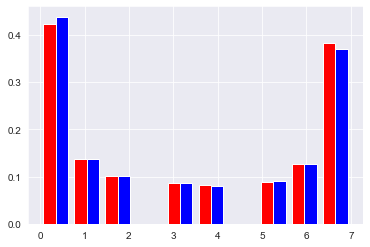

In [47]:
data=[marketing['ttl_login_days_l7'],holdout['ttl_login_days_l7']]
plt.hist(data,density=True,histtype='bar',stacked=False,color=['red','blue'])